In [1]:
## import packages
import nltk
import re
import string
import pandas as pd
import numpy as np
import gensim
from gensim import corpora
import matplotlib.pyplot as plt
import json
import matplotlib.pyplot as plt


In [2]:
#Downloading nltk dependencies for google colab 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
from nltk.corpus import stopwords
## Importing and preprocessing data

df = pd.read_csv('/content/Topic_data.csv')

df_filt = df.loc[df['Predicted_Scams']==False]

##Data Filtering
print(df_filt.shape)
df_filt['tokenized'] = df_filt['Clean_Description'].apply(lambda x: nltk.word_tokenize(x.lower()))
lmtzr = nltk.stem.WordNetLemmatizer()

stop = stopwords.words('english')  # Corpus

df_filt['stopwords_removed'] = df_filt['tokenized'].apply(lambda x: [word for word in x if word not in stop if word.isalpha()])
df_filt['QR_removed'] = df_filt['tokenized'].apply(lambda x: [word for word in x if word not in ('qr', 'code', 'link', 'to', 'this', 'post')]) #removing the noise from the data
df_filt['joined'] = df_filt['QR_removed'].apply(lambda x: " ".join(x))



(486, 4)


<ipython-input-3-7792f7e03616>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['tokenized'] = df_filt['Clean_Description'].apply(lambda x: nltk.word_tokenize(x.lower()))
<ipython-input-3-7792f7e03616>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['stopwords_removed'] = df_filt['tokenized'].apply(lambda x: [word for word in x if word not in stop if word.isalpha()])
<ipython-input-3-7792f7e03616>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [4]:
#Trigram
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in df_filt.joined])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

#processing the data for trigrams
from nltk.corpus import stopwords

stop_word_list = set(stopwords.words("english"))


# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_word_list or trigram[-1] in stop_word_list or trigram[1] in stop_word_list:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True



filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram:trigram_filter(trigram['trigram']) and trigram.pmi > 5, axis = 1)][:500]



trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

reviews_w_ngrams = df_filt['joined'].copy()
reviews_w_ngrams = pd.DataFrame(reviews_w_ngrams)

# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x
#Join
reviews_w_ngrams.joined = reviews_w_ngrams.joined.map(lambda x: replace_ngram(x))

# tokenize reviews + remove stop words + remove names + remove words with less than 2 characters
reviews_w_ngrams = reviews_w_ngrams.joined.map(lambda x: [word for word in x.split()\
                                                 if word not in stop_word_list\
                                                              and word not in stop\
                                                              and len(word) > 2])


In [5]:
##Filtering for nouns

def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

final_reviews = reviews_w_ngrams.map(noun_only)

In [6]:
##Document Matrix
dictionary = corpora.Dictionary(final_reviews)

doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_reviews]


#Finding the ideal number of topics
coherence = []
for k in range(5,25):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,\
                   iterations=500, chunksize = 100, eval_every = None)

    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_reviews,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))



Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24


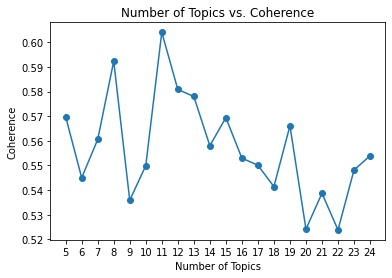

In [7]:
##Plotting Coherence

x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()



In [15]:
##Hyper Parameter Tuning
ldamodel3 = gensim.models.ldamodel.LdaModel
ldamodel3 = ldamodel3(doc_term_matrix, num_topics=8, id2word = dictionary, passes=60,\
               iterations=250,  chunksize = 250, eval_every = None, random_state=15000)


In [9]:
#Model 2
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=9, id2word = dictionary, passes=40,\
               iterations=250,  chunksize = 500, eval_every = None, random_state=0)

In [10]:
pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=c26676c2e6d3593337e13f3c5bf3aeb1ac687181797b4ab07951fc587a641f27
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=f4369c00938a9a990cabb986f3ebf55213abcd1809751d96e120a508da3d5246
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn


In [16]:
#Visulaizing the Topics using pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

topic_data =  gensimvis.prepare(ldamodel3, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [17]:
all_topics = {}
num_terms = 10 # Adjust number of words to represent each topic
lambd = .31 # Adjust this accordingly based on tuning above
for i in range(1,9): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [18]:
pd.DataFrame(all_topics).T

,0,1,2,3,4,5,6,7,8,9
Topic 1,michigan_mi_*,ohio_oh_*,park_il_*,indiana,wisconsin_wi_*,sale,illinois_il_*,truck,car,valley_il_*
Topic 2,grove,park,saint,ridge,palatine,evanston,buffalo,skokie,sportwagen,center
Topic 3,carvana,toyota,volkswagen,system,group,power,experience,email,budget,head
Topic 4,cherokee,inc.,f150,reserve,pay,suv,subaru,cylinder,vvt,audi
Topic 5,foot,box,delivery,fedex,contractor,liftgate,ft_box_truck,cube,econoline,"carpenter_,_roofer"
Topic 6,vehicle,retailer,autonation,process,consumer,show,credit✔️,approach,decision,desire
Topic 7,chicago,income,schaumburg,honda,copy,park,soul,melrose,payment,berwyn
Topic 8,lincoln,mkc,battery,tractor,loader,rust,shape,daewoo,genie,hyster
